# IMPORTS

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, AveragePooling1D
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from config.metadata import PATHS
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from config.metadata import PATHS
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow.keras.layers import (
    Dense,
    LSTM,
   
)
from tensorflow.keras.models import Sequential





In [29]:
def custom_loss(y_true, y_pred):
    # Definir los pesos para cada hora del día
    weights = np.ones(24) 
    weights[0] = 2
    weights[6:9] = 3
    weights[9] = 2  # Peso mayor para las horas de 6 a 8 de la mañana
    weights[18:20]  = 2
    weights[20:22] = 3  # Peso mayor para las horas de 8 a 10 de la noche
    weights[22:24] = 2
    # Calcular los errores ponderados
    errors = tf.abs(y_true - y_pred)
    weighted_errors = tf.pow(errors , weights)
    
    # Calcular la métrica de pérdida como la suma de los errores ponderados
    loss = tf.reduce_sum(weighted_errors)
    
    return loss

def create_sequences(data, seq_length, future_steps):
    X = []
    y = []
    for i in range(0, len(data) - seq_length - future_steps + 1, 24):
        X.append(data.iloc[i:i+seq_length, :])
        y.append(data.iloc[i+seq_length:i+seq_length+future_steps, 0])
    return np.array(X), np.array(y)



# PARAMS

In [30]:
model_days = 90
validation_days = 7
test_days = 14
seq_length = 24
future_steps = 24

# LOAD DATA

In [31]:
# Cargar los datos
df = pd.read_excel(
    os.path.join(PATHS['LOCAL']['root'], 'datasets', 'dataset_input_v1_2.xlsx')
)

df = df.rename(columns={'EUA': 'co2'})
df['fechaHora'] = pd.to_datetime(df['fechaHora'])

df = df.dropna(subset=['precio_spot'])


Nos quedamos con los 'n' ultimos datos del dataframe (segun parametro model_days)

In [32]:


now = pd.Timestamp.now()
last_day = df['fechaHora'].iloc[-1]
# Calcula la fecha hace dos meses utilizando timedelta
fecha_start = (last_day - pd.Timedelta(days=model_days)).replace(hour=0, minute=0, second=0)

# Filtra las filas correspondientes a los últimos dos meses
df_recent_data = df[df['fechaHora'] >= fecha_start]
df_recent_data.loc[:,'precio_spot'] = np.where(df_recent_data['precio_spot'] < 0, 0, df_recent_data['precio_spot'])




C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\3487348636.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
start_val = (last_day - pd.Timedelta(days= validation_days + test_days)).replace(hour=0, minute=0, second=0)

start_test = (last_day - pd.Timedelta(days=test_days)).replace(hour=0, minute=0, second=0)
# Suponiendo que df es tu DataFrame y 'fechaHora' está en formato datetime

# Dividir el DataFrame en conjunto de entrenamiento y conjunto de prueba
train_data = df_recent_data[df_recent_data['fechaHora'] < start_val]
val_data = df_recent_data[(start_val <= df_recent_data['fechaHora']) & (df_recent_data['fechaHora'] < start_test)]
test_data = df_recent_data[  start_test <= df_recent_data['fechaHora']]

# Verificar los tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", len(train_data))
print("Tamaño del conjunto de validacion:", len(val_data))

print("Tamaño del conjunto de prueba:", len(test_data))


Tamaño del conjunto de entrenamiento: 1655
Tamaño del conjunto de validacion: 168
Tamaño del conjunto de prueba: 360


Visualizamos la serie temporal divido en train, validation y test

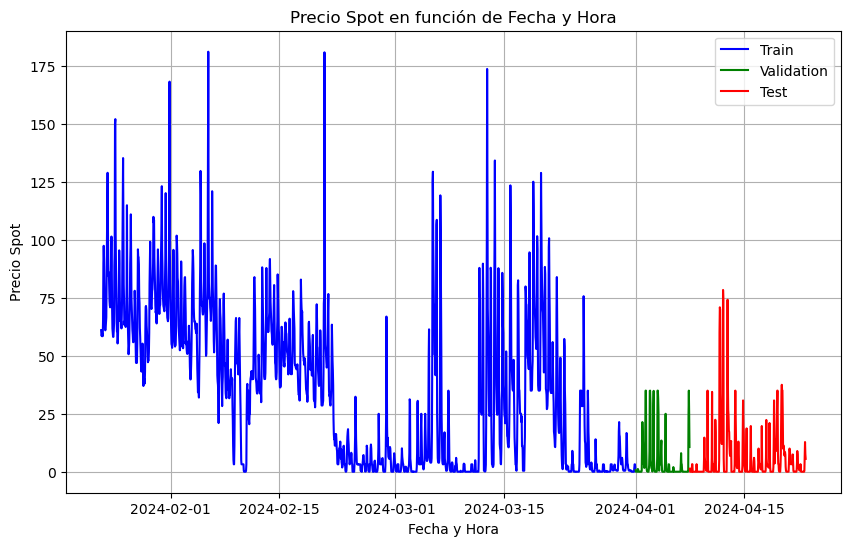

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['fechaHora'], train_data['precio_spot'], color='blue', label='Train')
plt.plot(val_data['fechaHora'], val_data['precio_spot'], color='green', label='Validation')

plt.plot(test_data['fechaHora'], test_data['precio_spot'], color='red', label='Test')

plt.xlabel('Fecha y Hora')
plt.ylabel('Precio Spot')
plt.title('Precio Spot en función de Fecha y Hora')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
train_data.drop(columns=['fechaHora'], inplace=True)
val_data.drop(columns=['fechaHora'], inplace=True)
test_data.drop(columns=['fechaHora'], inplace=True)


data = df_recent_data.copy()
# data = data.reset_index(drop=True)


C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\2604526388.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\2604526388.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\2604526388.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# DATA NORMALIZATION

## TRAIN

In [36]:
# Preprocesamiento de datos
# scaler_precio_spot = MinMaxScaler()
scaler_precio_spot = StandardScaler()
train_data['precio_spot'] = scaler_precio_spot.fit_transform(train_data[['precio_spot']])

scaler_demanda = MinMaxScaler()
train_data['demanda'] = scaler_demanda.fit_transform(train_data[['demanda']])

scaler_co2 = MinMaxScaler()
train_data['co2'] = scaler_co2.fit_transform(train_data[['co2']])

scaler_precio_gas = MinMaxScaler()
train_data['precio_gas'] = scaler_precio_gas.fit_transform(train_data[['precio_gas']])

scaler_prod_eolica = MinMaxScaler()
train_data['prod_eolica'] = scaler_prod_eolica.fit_transform(train_data[['prod_eolica']])

scaler_prod_solar = MinMaxScaler()
train_data['prod_solar'] = scaler_prod_solar.fit_transform(train_data[['prod_solar']])

scaler_demanda_residual = MinMaxScaler()
train_data['demanda_residual'] = scaler_demanda_residual.fit_transform(train_data[['demanda_residual']])

scaler_rampa = MinMaxScaler()
train_data['rampa'] = scaler_rampa.fit_transform(train_data[['rampa']])



C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\667146575.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\667146575.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\667146575.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

## VAL

In [37]:

val_data['precio_spot'] = scaler_precio_spot.transform(val_data[['precio_spot']])

val_data['demanda'] = scaler_demanda.transform(val_data[['demanda']])

val_data['co2'] = scaler_co2.transform(val_data[['co2']])

val_data['precio_gas'] = scaler_precio_gas.transform(val_data[['precio_gas']])

val_data['prod_eolica'] = scaler_prod_eolica.transform(val_data[['prod_eolica']])

val_data['prod_solar'] = scaler_prod_solar.transform(val_data[['prod_solar']])

val_data['demanda_residual'] = scaler_demanda_residual.transform(val_data[['demanda_residual']])

val_data['rampa'] = scaler_rampa.transform(val_data[['rampa']])

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\2127852279.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\2127852279.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\2127852279.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

## TEST

In [38]:

test_data['precio_spot'] = scaler_precio_spot.transform(test_data[['precio_spot']])

test_data['demanda'] = scaler_demanda.transform(test_data[['demanda']])

test_data['co2'] = scaler_co2.transform(test_data[['co2']])

test_data['precio_gas'] = scaler_precio_gas.transform(test_data[['precio_gas']])

test_data['prod_eolica'] = scaler_prod_eolica.transform(test_data[['prod_eolica']])

test_data['prod_solar'] = scaler_prod_solar.transform(test_data[['prod_solar']])

test_data['demanda_residual'] = scaler_demanda_residual.transform(test_data[['demanda_residual']])

test_data['rampa'] = scaler_rampa.transform(test_data[['rampa']])


C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\616695112.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\616695112.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicov\AppData\Local\Temp\ipykernel_27948\616695112.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [39]:
train_data

,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
44351,0.770819,0.733108,0.785203,0.835796,0.391284,0.000335,0.576000,0.545909
44352,0.707116,0.687758,0.785203,0.835796,0.379745,0.000340,0.535158,0.589663
44353,0.691948,0.657042,0.785203,0.835796,0.363580,0.000349,0.516979,0.540165
44354,0.733507,0.643636,0.785203,0.835796,0.342216,0.000335,0.505366,0.525824
44355,0.691948,0.643850,0.785203,0.835796,0.323751,0.000368,0.507994,0.494721
...,...,...,...,...,...,...,...,...
46001,-1.082651,0.663200,0.721559,0.840722,0.543386,0.195930,0.365279,0.265628
46002,-1.031385,0.733499,0.721559,0.840722,0.623162,0.027047,0.456834,0.300500
46003,-0.985579,0.789406,0.721559,0.840722,0.690979,0.008862,0.496384,0.414082
46004,-0.985579,0.753214,0.721559,0.840722,0.676902,0.008560,0.411268,0.686359


# CREATE SEQUENCES

Existen multiples formas de crear secuencias dentro de nuestra serie temporal para el entrenamiento. La mas comun suele ser coger una secuencia de longitud 'n' para predecir el valor 'n+1', posteriormennte desplazamos la serie en 1 unidad y volvemos a crear una secuencia de longitud 'n' en la que su ultimo valor sera 'n+1' y se predecira 'n+2'.

Esta seria una implementacion correcta, pero no la mas adecuada para nuestro problema. Nosotros, en primer lugar, debemos predecir los proximos 24 valores, no uno unico. Ademas como hemos visto nuestra serie temporal tiene una distribucion concreta, con 2 tramos horarios con valores mas elevados (picos), y con la implementacion anterior esta componente temporal se perderia. Por todo ello nuestra implementacion es la siguiente:
- Tomamos los primeros 24 valores, comenzando a las 00:00 de un dia 't'. (x)
- Con estos valores se predeciran los 24 proximos. (y)
- El desplazamiento sera de 24, de esta forma la siguiente secuencia en vez de comenzar a la 01:00 de 't' comenzara a las 00:00 de 't+1'.

El hecho de tomar los primeros 24 valores es para predecir con los datos del dia anterior (empiricamente es lo que mejores resultados da), pero esto se puede modificar mediante el parametro 'seq_lenght' pudiendo predecir en base a los 2 ultimos dias (seq_length=48) por ejemplo.

In [40]:
X_train, y_train = create_sequences(train_data, seq_length, future_steps)
X_val, y_val = create_sequences(val_data, seq_length, future_steps)
X_test, y_test = create_sequences(test_data, seq_length, future_steps)

y_val = scaler_precio_spot.inverse_transform(y_val)
y_test = scaler_precio_spot.inverse_transform(y_test)



Vemos como se han creado 67 secuencias de entrenamiento de longitud 24 (1 dia) con sus 8 variables exogenas

In [41]:
X_train.shape

(67, 24, 8)

# MODELLING

## BASIC

In [42]:
cnn_basic = Sequential()
cnn_basic.add(Conv1D(filters=16, kernel_size=12, activation='elu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_basic.add(MaxPooling1D(pool_size=2))
cnn_basic.add(Flatten())
cnn_basic.add(Dense(24))  # Capa de salida con 24 neuronas para las 24 horas del día
cnn_basic.compile(optimizer='adam', loss=custom_loss)
history =cnn_basic.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose = 1)

Epoch 1/50
5/5 [==============================] - 1s 47ms/step - loss: 497.7414 - val_loss: 2408832.0000
Epoch 2/50
5/5 [==============================] - 0s 9ms/step - loss: 387.2576 - val_loss: 2412978.7500
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 343.2086 - val_loss: 2405394.5000
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 299.6246 - val_loss: 2405725.2500
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 263.8161 - val_loss: 2414524.5000
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 228.3219 - val_loss: 2424907.5000
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 220.7085 - val_loss: 2423641.2500
Epoch 8/50
5/5 [==============================] - 0s 8ms/step - loss: 201.8400 - val_loss: 2429687.2500
Epoch 9/50
5/5 [==============================] - 0s 10ms/step - loss: 188.5379 - val_loss: 2433796.5000
Epoch 10/50
5/5 [==============================] - 0s 8ms/step

Mean Squared Error (MSE): 111.54049843407465
Mean Absolute Error (MAE): 6.059557480799654
Valor de custom loss: 359329.3680198139


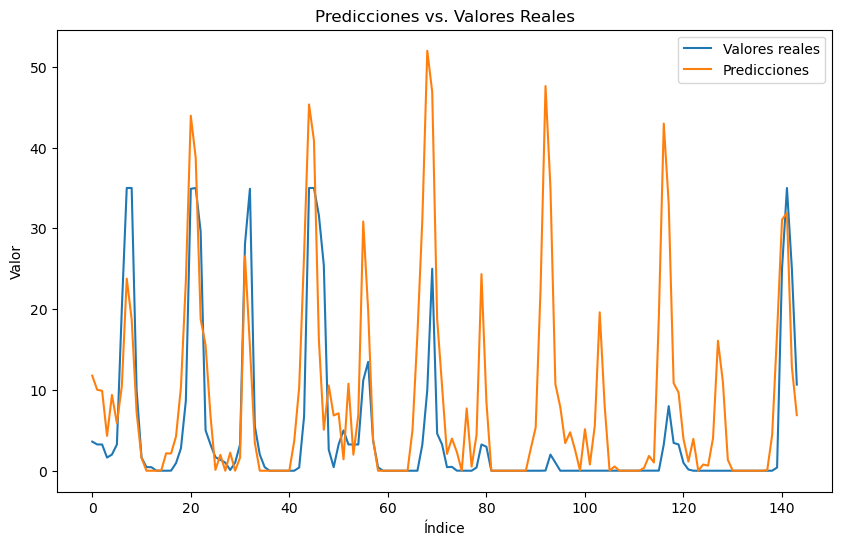

In [43]:
y_pred_basic = cnn_basic.predict(X_val, verbose=0)

y_pred_basic = scaler_precio_spot.inverse_transform(y_pred_basic)
y_pred_basic = np.where(y_pred_basic < 0, 0, y_pred_basic)

mse = mean_squared_error(y_val, y_pred_basic)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_val, y_pred_basic)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_val, y_pred_basic)
print("Valor de custom loss:", metric_value.numpy())

# Plot de las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Valores reales')
plt.plot(y_pred_basic.flatten(), label='Predicciones')
# plt.plot(np.array(df_last2['precio_spot']), label='ts')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

En este primer modelo basico obtenemos unos resultados decentes pero muy mejorables, no se ajusta muy bien a los picos.

## MULTILAYER

Probamos ahora con modelos mas profundos. Computacionalmente seran mas costosos pero pueden captar patrones mas complejos.

In [61]:
cnn_multi = Sequential()
cnn_multi.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_multi.add(MaxPooling1D(2))
cnn_multi.add(Conv1D(64, 3, activation='relu'))
cnn_multi.add(MaxPooling1D(2))
cnn_multi.add(Conv1D(128, 3, activation='relu'))
cnn_multi.add(MaxPooling1D(2))
cnn_multi.add(Flatten())
cnn_multi.add(Dense(64, activation='relu'))
cnn_multi.add(Dense(24))  # Capa de salida con 24 neuronas para las 24 horas del día

cnn_multi.compile(optimizer='adam', loss=custom_loss)
history =cnn_multi.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose = 1)

Epoch 1/50
3/3 [==============================] - 2s 120ms/step - loss: 979.2252 - val_loss: 2445577.5000
Epoch 2/50
3/3 [==============================] - 0s 17ms/step - loss: 815.4230 - val_loss: 2414598.0000
Epoch 3/50
3/3 [==============================] - 0s 16ms/step - loss: 747.5590 - val_loss: 2388516.5000
Epoch 4/50
3/3 [==============================] - 0s 17ms/step - loss: 694.6783 - val_loss: 2395887.2500
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 611.8344 - val_loss: 2425214.7500
Epoch 6/50
3/3 [==============================] - 0s 18ms/step - loss: 547.7315 - val_loss: 2448673.2500
Epoch 7/50
3/3 [==============================] - 0s 17ms/step - loss: 503.6872 - val_loss: 2455668.0000
Epoch 8/50
3/3 [==============================] - 0s 17ms/step - loss: 470.9726 - val_loss: 2459302.7500
Epoch 9/50
3/3 [==============================] - 0s 16ms/step - loss: 456.8409 - val_loss: 2451164.2500
Epoch 10/50
3/3 [==============================] - 0s 

Mean Squared Error (MSE): 89.06748770156975
Mean Absolute Error (MAE): 5.23921734885442
Valor de custom loss: 256277.49198600813


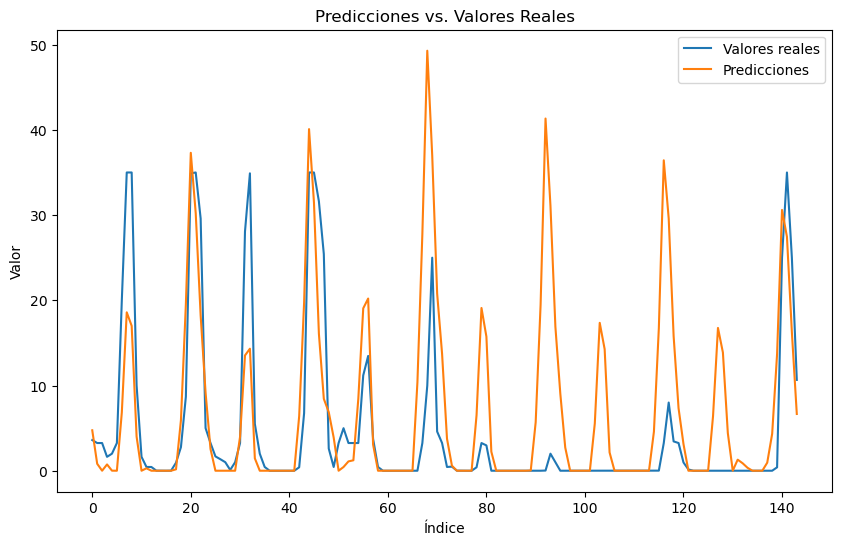

In [62]:
y_pred_multi = cnn_multi.predict(X_val, verbose=0)

y_pred_multi = scaler_precio_spot.inverse_transform(y_pred_multi)
y_pred_multi = np.where(y_pred_multi < 0, 0, y_pred_multi)

mse = mean_squared_error(y_val, y_pred_multi)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_val, y_pred_multi)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_val, y_pred_multi)
print("Valor de custom loss:", metric_value.numpy())

# Plot de las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Valores reales')
plt.plot(y_pred_multi.flatten(), label='Predicciones')
# plt.plot(np.array(df_last2['precio_spot']), label='ts')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

Como podemos ver este modelo da unos resultados mejores que los anterirores. Los picos siguen sin ajustarse muy bien pero se nota la mejoria respecto al modelo simple. Trataremos ahora de mejorarlo mediante el uso de capas con dropout y regularizacion.

### DROPOUT + REGULARIZER

In [46]:
cnn_drop = Sequential()
cnn_drop.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_drop.add(MaxPooling1D(2))
cnn_drop.add(Dropout(0.2))  # Dropout con probabilidad de 0.5
cnn_drop.add(Conv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_drop.add(MaxPooling1D(2))
cnn_drop.add(Dropout(0.2))  # Dropout con probabilidad de 0.5
cnn_drop.add(Conv1D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_drop.add(MaxPooling1D(2))
cnn_drop.add(Flatten())
cnn_drop.add(Dense(64, activation='relu'))
cnn_drop.add(Dense(24))  # Capa de salida con 24 neuronas para las 24 horas del día

cnn_drop.compile(optimizer='adam', loss=custom_loss)
history =cnn_drop.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose = 1)

Epoch 1/100
3/3 [==============================] - 2s 128ms/step - loss: 981.7017 - val_loss: 2450686.7500
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 790.1241 - val_loss: 2429174.5000
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 732.3792 - val_loss: 2408570.5000
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 688.6627 - val_loss: 2406001.5000
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 636.8409 - val_loss: 2418906.0000
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 599.6744 - val_loss: 2437396.7500
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 589.2656 - val_loss: 2449878.5000
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 549.5572 - val_loss: 2457009.5000
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 529.9014 - val_loss: 2459116.5000
Epoch 10/100
3/3 [===========================

Mean Squared Error (MSE): 100.18802656143664
Mean Absolute Error (MAE): 7.60979855356531
Valor de custom loss: 194645.0843129837


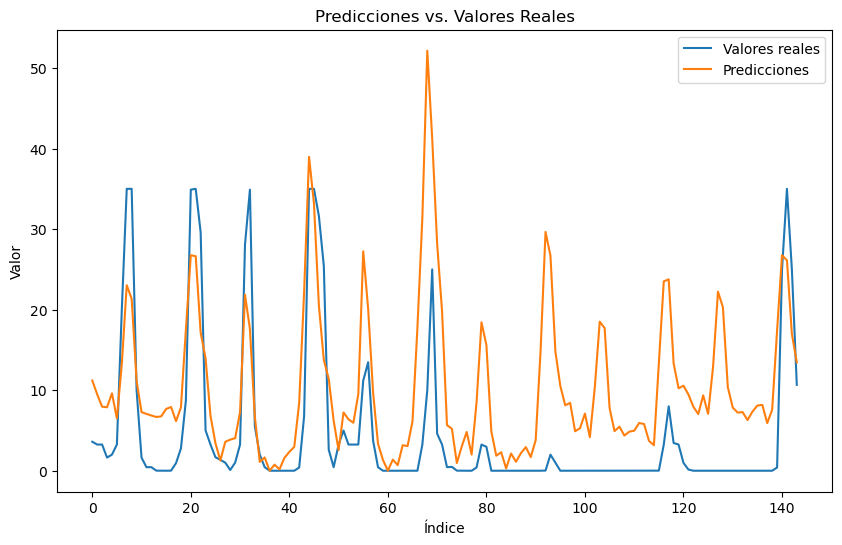

In [47]:
y_pred_drop = cnn_drop.predict(X_val, verbose=0)

y_pred_drop = scaler_precio_spot.inverse_transform(y_pred_drop)
y_pred_drop = np.where(y_pred_drop < 0, 0, y_pred_drop)

mse = mean_squared_error(y_val, y_pred_drop)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_val, y_pred_drop)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_val, y_pred_drop)
print("Valor de custom loss:", metric_value.numpy())

# Plot de las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Valores reales')
plt.plot(y_pred_drop.flatten(), label='Predicciones')
# plt.plot(np.array(df_last2['precio_spot']), label='ts')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

En este caso nuestro modelo no se ve beneficiado por el uso de dropout y regularizacion. Los resultados son notablemente peores, los valles no se logran modelar correctamente y los picos tampoco.

Por ultimo implementamos un modelo hibrido que combina las 2 tecnologias anterirores, las LSTM y CNN.

## LSTM + CNN

En esta implementacion combinaremos nuestro modelo CNN con capas LSTM.

In [48]:
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm.add(MaxPooling1D(2))
cnn_lstm.add(Conv1D(64, 3, activation='relu'))
cnn_lstm.add(MaxPooling1D(2))
cnn_lstm.add(Conv1D(128, 3, activation='relu'))
cnn_lstm.add(MaxPooling1D(2))
# cnn_lstm.add(Flatten())
cnn_lstm.add(Dense(24))  
# Agregar capa LSTM
cnn_lstm.add(LSTM(units=128, return_sequences=True)) 
cnn_lstm.add(LSTM(units=64))  # Puedes ajustar el número de unidades LSTM según tus necesidades
 # Puedes ajustar el número de unidades LSTM según tus necesidades
# La salida de LSTM es (batch_size, units)
cnn_lstm.add(Dense(24))  


cnn_lstm.compile(optimizer='adam', loss=custom_loss)
history =cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose = 1)

Epoch 1/50
5/5 [==============================] - 7s 302ms/step - loss: 499.4431 - val_loss: 2470204.7500
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 485.8328 - val_loss: 2453081.2500
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 444.1487 - val_loss: 2413370.7500
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 391.2960 - val_loss: 2375700.5000
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 358.6337 - val_loss: 2394438.7500
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 320.6389 - val_loss: 2432218.7500
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 306.3670 - val_loss: 2449333.5000
Epoch 8/50
5/5 [==============================] - 0s 13ms/step - loss: 278.1544 - val_loss: 2463998.2500
Epoch 9/50
5/5 [==============================] - 0s 13ms/step - loss: 265.8087 - val_loss: 2473218.7500
Epoch 10/50
5/5 [==============================] - 0s 

Mean Squared Error (MSE): 71.86454525673619
Mean Absolute Error (MAE): 4.98025369528736
Valor de la métrica personalizada: 154679.58047860512


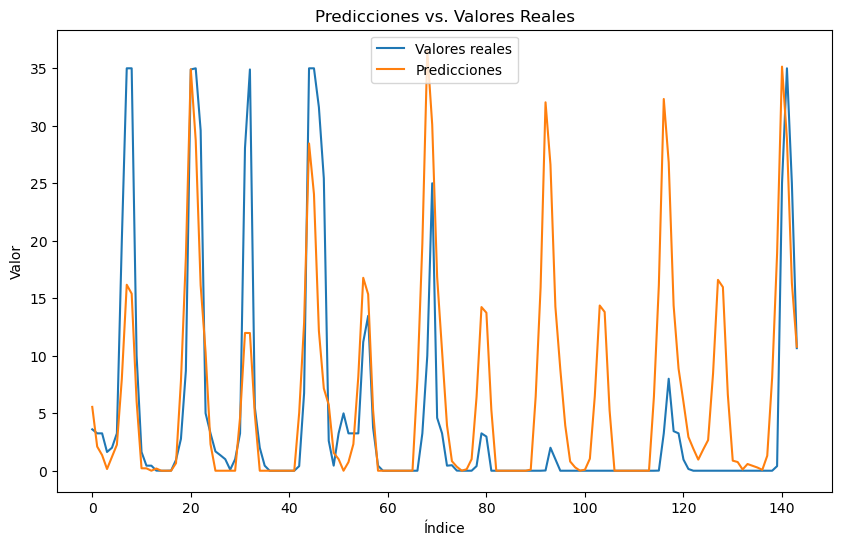

In [49]:

y_pred_cnn_lstm = cnn_lstm.predict(X_val, verbose=0)

y_pred_cnn_lstm = scaler_precio_spot.inverse_transform(y_pred_cnn_lstm)
y_pred_cnn_lstm = np.where(y_pred_cnn_lstm < 0, 0, y_pred_cnn_lstm)


mse = mean_squared_error(y_val, y_pred_cnn_lstm)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_val, y_pred_cnn_lstm)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_val, y_pred_cnn_lstm)
print("Valor de la métrica personalizada:", metric_value.numpy())

# Plot de las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Valores reales')
plt.plot(y_pred_cnn_lstm.flatten(), label='Predicciones')
# plt.plot(np.array(df_last2['precio_spot']), label='ts')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()


Obtenemos un modelo con metricas ligeramente mejores que las del modelo multicapa sin dropout. Los valles se modelan correctamente y los picos se ajustan mejor que en otras implementaciones. 

## GRID SEARCH

In [50]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
# from scikeras.wrappers import KerasRegressor
# from sklearn.model_selection import GridSearchCV
# from keras.optimizers import Adam, RMSprop

# # Función para crear el modelo
# def create_model(activation='relu', filters_per_layer=[64, 32], kernel_size_per_layer=[3, 3], optimizer=Adam()):
#     cnn_multi = Sequential()
#     for filters, kernel_size in zip(filters_per_layer, kernel_size_per_layer):
#         cnn_multi.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
#         cnn_multi.add(MaxPooling1D(pool_size=2))
#     cnn_multi.add(Flatten())
#     cnn_multi.add(Dense(50, activation=activation))
#     cnn_multi.add(Dense(24))
#     cnn_multi.compile(optimizer=optimizer, loss=custom_loss)
#     return cnn_multi

# # Wrapping del modelo Keras para usarlo con scikit-learn
# model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=1)

# # Definir los parámetros a explorar
# param_grid = {
#     'activation': ['relu', 'elu'],
#     'filters_per_layer': [[32, 64], [64, 32, 16], [128, 64, 32]],
#     'kernel_size_per_layer': [(3, 3), (5, 5), (3, 5)],
#     'optimizer': [Adam(), RMSprop()]
# }

# # Realizar la búsqueda de hiperparámetros
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid_search.fit(X_train, y_train)

# # Mostrar los resultados
# print("Mejor resultado: %f utilizando %s" % (grid_result.best_score_, grid_result.best_params_))


In [51]:
# model.get_params().keys()

Los resultados de este modelo hibrido son ligeramente peores que los de la CNN sola, parece que tiende sobreestimar el valor real tanto en los picos como en los valles. Por tanto descartamos este modelo y seleccionamos la CNN como modelo ganador.

# MODELS COMPARATIVE

Compararemos las graficas de los 2 mejores modelos con el fin de seleccionar uno de ellos como ganador. Estos modelos seran la CNN multicapa sin dropout ni regularizacion, y el modelo que combina capas CNN con LSTM.

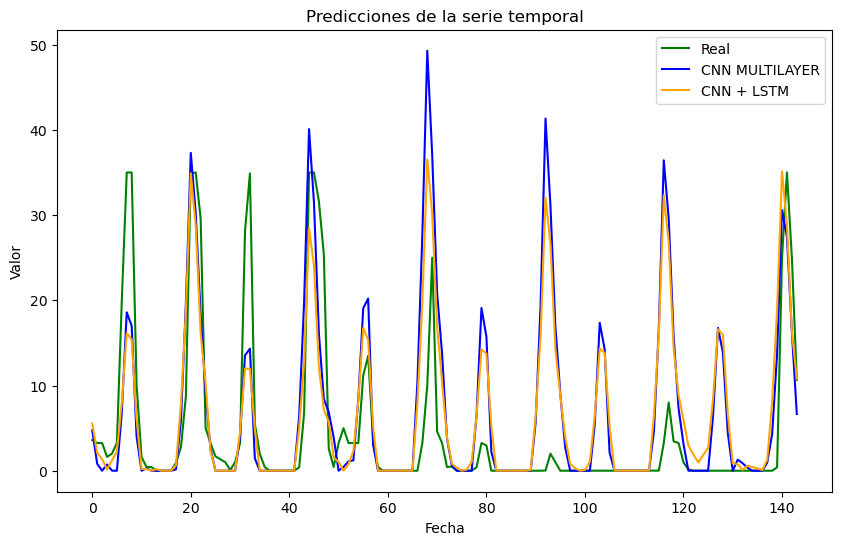

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Real', color='green')
plt.plot(y_pred_multi.flatten(), label='CNN MULTILAYER', color='blue')
plt.plot(y_pred_cnn_lstm.flatten(), label='CNN + LSTM ', color='orange')

plt.title('Predicciones de la serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [64]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Crear la figura
fig = make_subplots(rows=1, cols=1)

# Agregar las líneas de datos
fig.add_trace(go.Scatter(x=list(range(len(y_val.flatten()))), y=y_val.flatten(), mode='lines', name='Real', line=dict(color='green')))
fig.add_trace(go.Scatter(x=list(range(len(y_pred_basic.flatten()))), y=y_pred_basic.flatten(), mode='lines', name='CNN BASIC', line=dict(color='red')))
fig.add_trace(go.Scatter(x=list(range(len(y_pred_multi.flatten()))), y=y_pred_multi.flatten(), mode='lines', name='CNN MULTILAYER', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=list(range(len(y_pred_drop.flatten()))), y=y_pred_drop.flatten(), mode='lines', name='CNN DROP + REG', line=dict(color='black')))
fig.add_trace(go.Scatter(x=list(range(len(y_pred_cnn_lstm.flatten()))), y=y_pred_cnn_lstm.flatten(), mode='lines', name='CNN + LSTM', line=dict(color='orange')))

# Actualizar el diseño del gráfico
fig.update_layout(title='Predicciones de la serie temporal', xaxis_title='Fecha', yaxis_title='Valor')

# Mostrar el gráfico
fig.show()


Como podemos ver ambos modelos predicen de forma muy similar. Puesto que la mayor dificultad se encuentra en hallar la magnitud de los picos y sus metricas son ligeramente mejores optamos por seleccionar como mejor modelo la red CNN con capas LSTM.

# TEST

Evaluamos el modelo ganador con los datos de test.

1/1 [==============================] - 0s 24ms/step
Mean Squared Error (MSE): 105.41291196833551
Mean Absolute Error (MAE): 5.396424008339
Valor de custom loss: 825214.8321280521


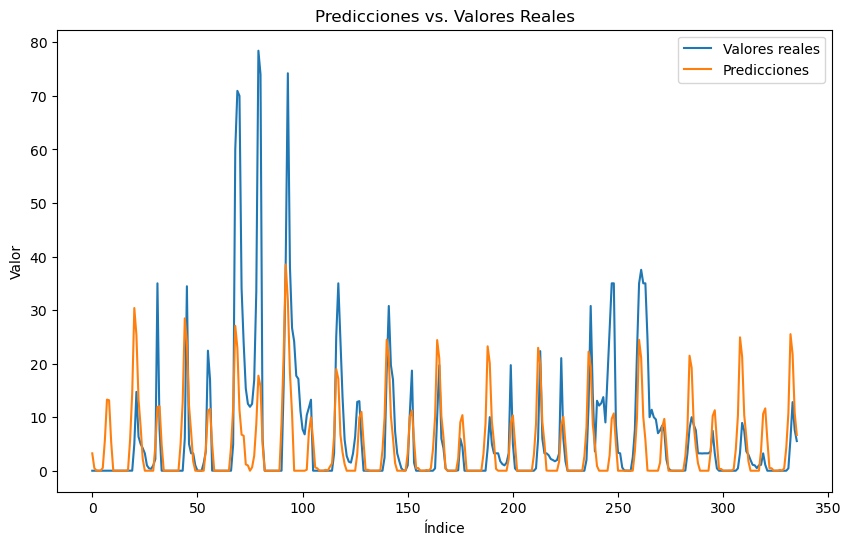

In [56]:

# Hacer predicciones
y_pred_test = cnn_lstm.predict(X_test)

y_pred_test = scaler_precio_spot.inverse_transform(y_pred_test)
y_pred_test = np.where(y_pred_test < 0, 0, y_pred_test)

mse = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_test, y_pred_test)
print("Valor de custom loss:", metric_value.numpy())


plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Valores reales')
plt.plot(y_pred_test.flatten(), label='Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

Como podemos observar en los datos de test obtenemos unas predicciones satisfactorias. En este tramo de 15 dias (360 horas) de media nos hemos equivocado tan solo en 5,39€, lo cual es un resultado positivo. En general los picos parecen predecirse correctamente, teniendo mayor dificultad en aquellos que se alejan de la magnitud usual de estos dias.